In [1]:
import sys
import astropy.units as u
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
import yaml
from gammapy.datasets import FluxPointsDataset, Datasets
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models, FoVBackgroundModel, Model
from matplotlib import rc
from scipy.interpolate import interp2d

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../../../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


(None, <pyximport.pyximport.PyxImporter at 0x7ff23455b1c0>)

## Read dataset

In [2]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1/60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)
dataset_input = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

shift = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.1

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / bias**2, 1 / zero**2, 1 / zero**2, 1 / zero**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["resolution"].frozen = True
dataset_asimov_N.irf_model.parameters["bias"].frozen = False


a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

datasets = Datasets(dataset_asimov)
datasets_N = Datasets(dataset_asimov_N)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [3]:
import json

def make_writeable(cc):
    d = dict()
    for ii, seg in enumerate(cc.allsegs[0]):
        d['x'] = seg[:,0].tolist()
        d['y'] = seg[:,1].tolist()
    return d

def save(c, name):
    d = make_writeable(c)
    with open(name, 'w') as f:
        json.dump(d, f)
        
def read(name):
    with open(name) as data_file:
        data_loaded = json.load(data_file)
    return data_loaded


asimov_model = Models.read("data/1_model.yml")
asimov_model_N = Models.read("data/1_model_N.yml")
def plot_best_fit(ax, par1, par2, factor1 =1 , factor2 =1):
    pp1, pp2 = asimov_model.parameters[par1], asimov_model.parameters[par2]
    ax.errorbar(pp1.value*factor1, pp2.value*factor2, xerr = pp1.error*factor1, yerr = pp2.error*factor2, 
                color = 'yellow',capsize = (4),  )
    ax.errorbar(pp1.value*factor1, pp2.value*factor2, xerr = pp1.error*factor1, yerr = pp2.error*factor2, 
                color = 'green',capsize = (4),  )
    pp1, pp2 = asimov_model_N.parameters[par1], asimov_model.parameters[par2]
    ax.errorbar(pp1.value*factor1, pp2.value*factor2, xerr = pp1.error*factor1, yerr = pp2.error*factor2, 
                color = 'blue', capsize = (4), linestyle = 'dashed')

## Standard 

In [4]:
fitting = 1
if fitting:
    fit = Fit(store_trace=False)
    result = fit.run(datasets)
    print(datasets.models)
print(result)

DatasetModels

Component 0: SkyModel

  Name                      : TQLL36So
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.07             
    amplitude                     :   1.00e-12   +/- 5.5e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : 622l4FQH-bkg
  Datasets names            : ['622l4FQH']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm

(array([2.15947624, 2.16232164, 2.16516703, 2.16801243, 2.17085782,
        2.17370322, 2.17654861, 2.17939401, 2.18223941, 2.1850848 ,
        2.1879302 , 2.19077559, 2.19362099, 2.19646638, 2.19931178,
        2.20215717, 2.20500257, 2.20784796, 2.21069336, 2.21353875,
        2.21638415, 2.21922954, 2.22207494, 2.22492033, 2.22776573,
        2.23061112, 2.23345652, 2.23630191, 2.23914731, 2.2419927 ,
        2.2448381 , 2.24768349, 2.25052889, 2.25337428, 2.25621968,
        2.25906507, 2.26191047, 2.26475587, 2.26760126, 2.27044666,
        2.27329205, 2.27613745, 2.27898284, 2.28182824, 2.28467363,
        2.28751903, 2.29036442, 2.29320982, 2.29605521, 2.29890061,
        2.301746  , 2.3045914 , 2.30743679, 2.31028219, 2.31312758,
        2.31597298, 2.31881837, 2.32166377, 2.32450916, 2.32735456,
        2.33019995, 2.33304535, 2.33589074, 2.33873614, 2.34158153,
        2.34442693, 2.34727233, 2.35011772, 2.35296312, 2.35580851,
        2.35865391, 2.3614993 , 2.3643447 , 2.36

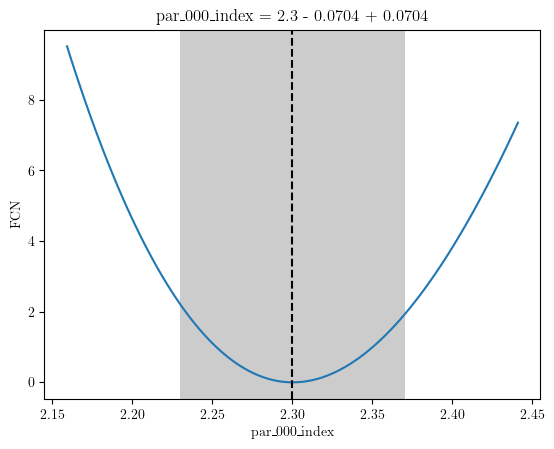

In [20]:
fit.minuit.draw_profile("par_000_index")

(array([0.89105888, 0.8932667 , 0.89547453, 0.89768235, 0.89989018,
        0.902098  , 0.90430582, 0.90651365, 0.90872147, 0.91092929,
        0.91313712, 0.91534494, 0.91755277, 0.91976059, 0.92196841,
        0.92417624, 0.92638406, 0.92859188, 0.93079971, 0.93300753,
        0.93521535, 0.93742318, 0.939631  , 0.94183883, 0.94404665,
        0.94625447, 0.9484623 , 0.95067012, 0.95287794, 0.95508577,
        0.95729359, 0.95950142, 0.96170924, 0.96391706, 0.96612489,
        0.96833271, 0.97054053, 0.97274836, 0.97495618, 0.97716401,
        0.97937183, 0.98157965, 0.98378748, 0.9859953 , 0.98820312,
        0.99041095, 0.99261877, 0.9948266 , 0.99703442, 0.99924224,
        1.00145007, 1.00365789, 1.00586571, 1.00807354, 1.01028136,
        1.01248918, 1.01469701, 1.01690483, 1.01911266, 1.02132048,
        1.0235283 , 1.02573613, 1.02794395, 1.03015177, 1.0323596 ,
        1.03456742, 1.03677525, 1.03898307, 1.04119089, 1.04339872,
        1.04560654, 1.04781436, 1.05002219, 1.05

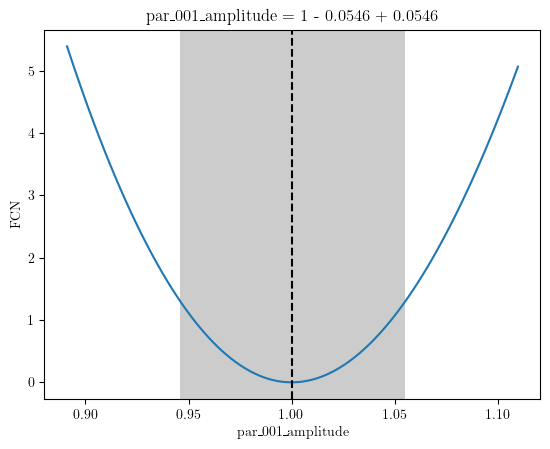

In [21]:
fit.minuit.draw_profile("par_001_amplitude")

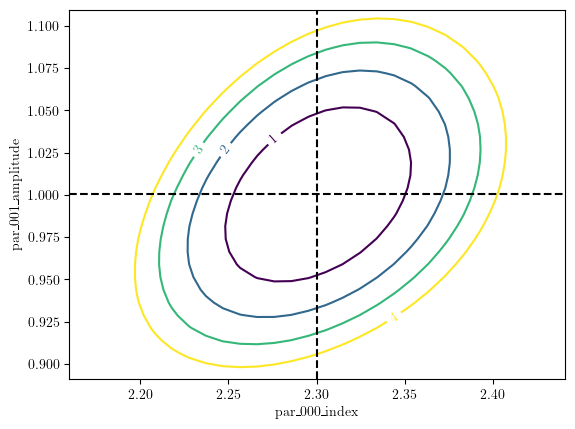

In [24]:
c = fit.minuit.draw_contour("par_000_index", "par_001_amplitude", 
                               size = 30, 
                               )


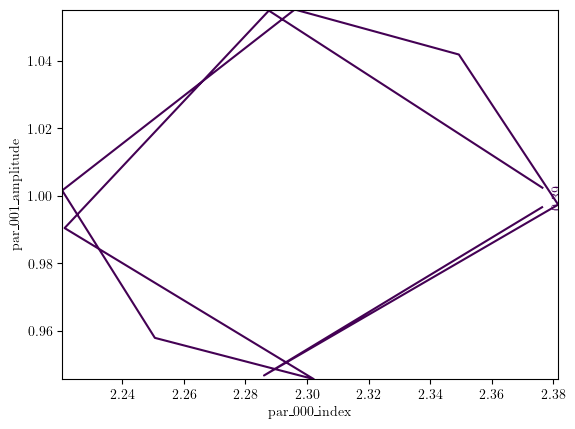

In [25]:
c = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.39, 
                               size = 10, 
                               )


E MnContours unable to find first two points


ValueError: zero-size array to reduction operation minimum which has no identity

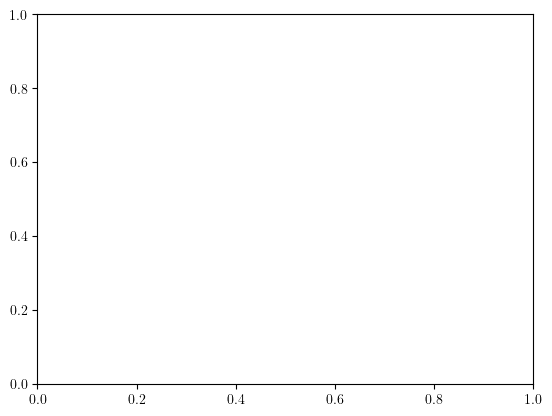

In [6]:
%%time

fitting = 1
if fitting :
    c = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.39, 
                                   size = 30, 
                                   )
    save(c, 'data/5_scan_39_index_amplitude.json')
    print("computing 68")
    c = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.68, 
                                   size = 30, 
                                   )
    #save(c, 'data/5_scan_68_index_amplitude.json')
    print("computing 95")
    c95 = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.95, 
                                   size = 100, 
                                   )
    #save(c95, 'data/5_scan_95_index_amplitude.json')
else:
    c_39_a_i = read('data/5_scan_39_index_amplitude.json')
    c_a_i = read('data/5_scan_68_index_amplitude.json')
    c95_a_i = read('data/5_scan_95_index_amplitude.json')
    plt.plot(c_a_i['x'], np.array(c_a_i['y']), '--', label='Standard 39 %', color = 'red')
    plt.plot(c_a_i['x'], np.array(c_a_i['y']), '.-', label='Standard 68%', color = 'red')
    plt.plot(c95_a_i['x'], np.array(c95_a_i['y']), '.-', label='Standard 95', color = 'red')
    
    plot_best_fit(plt.gca(), "index", "amplitude", factor2 = 1e12)

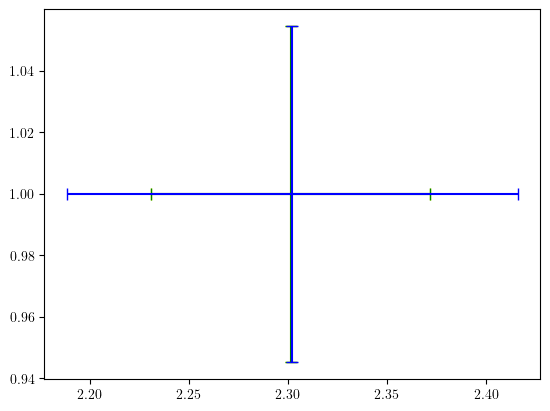

In [7]:
plot_best_fit(plt.gca(), "index", "amplitude", factor2 = 1e12)

CPU times: user 11.2 ms, sys: 106 µs, total: 11.3 ms
Wall time: 11.3 ms


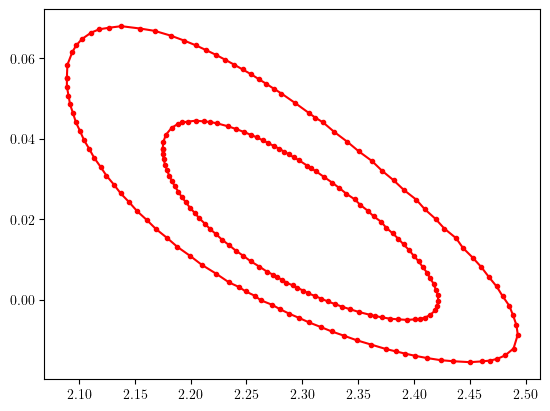

In [8]:
%%time
factor_lambda = 0.01

fitting = 0
if fitting :
    
    c = fit.minuit.draw_mncontour("par_000_index", "par_002_lambda_", 
                                   cl = 0.68, 
                                   size = 100, 
                                   )
    save(c, 'data/5_scan_68_index_lambda.json')
    print("computing 95")
    c95 = fit.minuit.draw_mncontour("par_000_index", "par_002_lambda_", 
                                   cl = 0.95, 
                                   size = 100, 
                                   )
    save(c95, 'data/5_scan_95_index_lambda.json')
else:
    c_i_l = read('data/5_scan_68_index_lambda.json')
    c95_i_l = read('data/5_scan_95_index_lambda.json')
    
    plt.plot(c_i_l['x'], np.array(c_i_l['y'])*factor_lambda, '.-', label='Standard 1$\sigma$', color = 'red')
    plt.plot(c95_i_l['x'], np.array(c95_i_l['y'])*factor_lambda, '.-', label='Standard 2$\sigma$', color = 'red')

CPU times: user 97.7 ms, sys: 21.2 ms, total: 119 ms
Wall time: 118 ms


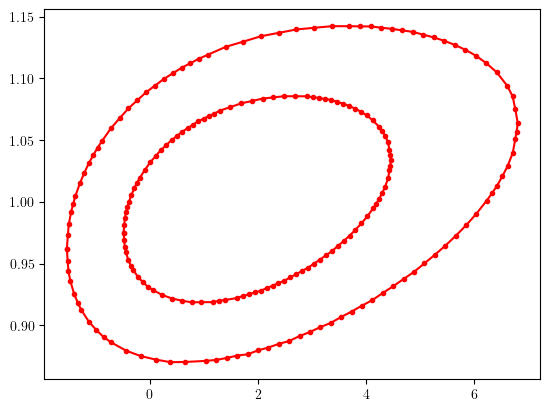

In [9]:
%%time

fitting = 0
if fitting :
    
    c = fit.minuit.draw_mncontour("par_002_lambda_", "par_001_amplitude", 
                                   cl = 0.68, 
                                   size = 100, 
                                   )
    save(c, 'data/5_scan_68_lambda_amplitude.json')
    print("computing 95")
    c95 = fit.minuit.draw_mncontour("par_002_lambda_", "par_001_amplitude", 
                                   cl = 0.95, 
                                   size = 100, 
                                   )
    save(c95, 'data/5_scan_95_lambda_amplitude.json')
else:
    c_l_a = read('data/5_scan_68_lambda_amplitude.json')
    c95_l_a = read('data/5_scan_95_lambda_amplitude.json')
    plt.plot(c_l_a['x'], np.array(c_l_a['y']), '.-', label='Standard 1$\sigma$', color = 'red')
    plt.plot(c95_l_a['x'], np.array(c95_l_a['y']), '.-', label='Standard 2$\sigma$', color = 'red')  

## Nuisance Parameters

In [10]:
datasets_N.models[0].spatial_model.parameters.freeze_all()

In [11]:
%%time
fitting= 1
if fitting: 
    minuit_opts = {"tol": 0.1, "strategy": 1}

    fit_N = Fit(store_trace=False)
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(datasets_N)
    print(result_N)
    print(datasets_N.models)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 161
	total stat : 850150.22

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

DatasetModels

Component 0: SkyModel

  Name                      : TQLL36So
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.11             
    amplitude                     :   1.00e-12   +/- 5.5e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    329.680       deg         
    lat_0      

In [12]:

size = (15,16,17)
#size = (2,3,4)


datasets_N.parameters["amplitude"].scan_n_sigma = 4
datasets_N.parameters["index"].scan_n_sigma = 4
datasets_N.parameters["lambda_"].scan_n_sigma = 4

datasets_N.parameters["amplitude"].scan_n_values = size[0]
datasets_N.parameters["index"].scan_n_values = size[1]
datasets_N.parameters["lambda_"].scan_n_values = size[2]

a_scan = datasets_N.parameters["amplitude"].scan_values.copy()
i_scan = datasets_N.parameters["index"].scan_values.copy()
l_scan = datasets_N.parameters["lambda_"].scan_values.copy()

scans = {"amplitude":a_scan,
        "index":i_scan,
        "lambda_":l_scan}

print(len(scans['amplitude']))
print(len(scans['index']))
print(len(scans['lambda_']))

15
16
17


In [13]:
parnames = ['lambda_', 'index', 'amplitude']

In [14]:
def compute_L(parname1, parname2, reopt = False, save = False):
    #datasets_N.parameters["amplitude"].scan_values = np.linspace(0.2e-12, 1.8e-12, 11 )
    #datasets_N.parameters["index"].scan_values = np.linspace(1.3, 3.3, 10 )
  
    
    par1 , par2 = datasets_N.parameters[parname1], datasets_N.parameters[parname2]
    scan_noopti = []
    for p in parnames:
        datasets_N.models.parameters[p].value = dataset_input.models.parameters[p].value  
        datasets_N.models.parameters[p].frozen = False  
        
    for a in scans[parname1]:
        scan_x = []
        for i in scans[parname2]:
            par1.value = a
            par2.value = i
            par1.frozen = True
            par2.frozen = True

            if reopt:
                result_N = fit_N.optimize(datasets_N)
                print(datasets_N.models)
                print(result_N)
                
            scan_x.append(datasets_N.stat_sum())
        scan_noopti.append(scan_x)
        
    if save: 
        with open(f"data/5a_2d_{parname1}_{parname2}.txt", "w") as f:
            np.savetxt(f, np.array(scan_noopti).flatten())

        with open(f"data/5a_{parname1}_{parname2[:1]}.txt", "w") as f:
            np.savetxt(f, scans[parname1])

        with open(f"data/5a_{parname2}_{parname1[:1]}.txt", "w") as f:
            np.savetxt(f, scans[parname2])

    return scan_noopti
  
  
def plot_imshow(scan, parname2, parname1):
    x_scan, y_scan = scans[parname1], scans[parname2] 
    fig = plt.figure()
    #im = plt.imshow(scan)
    im = plt.pcolormesh(x_scan, y_scan, scan)
    x_scan_ = x_scan.copy()
    y_scan_ = y_scan.copy()
    
    #if parname1 == "amplitude":
    #    x_scan_ = x_scan * 1e-12
    #if parname2 == "amplitude":
    #    y_scan_ = y_scan * 1e-12
    fig.colorbar(im)
    #plt.xticks(np.linspace(0,len(x_scan_)-1,len(x_scan_)), np.round(x_scan_,2));
    #plt.yticks(np.linspace(0,len(y_scan_)-1, len(y_scan_)), np.round(y_scan_,2));
    
    ax = plt.gca()
    ax.set_ylabel(parname2)
    ax.set_xlabel(parname1)  
    
    ax.plot(dataset_input.models.parameters[parname1].value,
           dataset_input.models.parameters[parname2].value,
           marker = '^', color = "white")
    
def read_L(parname1, parname2):
    print(f"{parname1}_{parname2}")
    scan =     np.loadtxt(f"data/5a_2d_{parname1}_{parname2}.txt")
    y0_scan =     np.loadtxt(f"data/5a_{parname1}_{parname2[:1]}.txt")
    x0_scan =     np.loadtxt(f"data/5a_{parname2}_{parname1[:1]}.txt")
    print("scan shape", np.shape(scan))
    print("scan x_scan", np.shape(x0_scan))
    print("scan y_scan", np.shape(y0_scan))
    
    scan = scan.reshape(len(y0_scan), len(x0_scan))
    print("scan shape", np.shape(scan))
    
    return scan, x0_scan, y0_scan



def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best


def plot_L(
    Ls_new,
    x_new,
    y_new,
    threshold,
    find_min,
    color="red",
    ax=None,
    fig=None,
    cbar=True,
    cmap="viridis",
):
    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min=find_min
    )
    if ax is None:
        fig, ax = plt.subplots(
            1,
            1,
        )

    im = ax.pcolormesh(x_new, y_new, Ls_new, cmap=cmap, rasterized=True)
    if cbar:
        fig.colorbar(im)

    CS = ax.contour(
        x_new, y_new, Ls_new, colors=(color,), levels=[Ls_new.min() + threshold]
    )
    # ax.clabel(CS, CS.levels, inline=True, fmt='$1\\sigma$', fontsize=12)

    plot_errors(
        ax,
        x_new,
        y_new,
        index_min,
        index_max,
        ampli_min,
        ampli_max,
        index_best,
        ampli_best,
        color,
    )

    ax.plot(ampli_best, index_best, "x", color=color)

    ax.set_ylabel(f"Amplitude [{a_unit}]")
    ax.set_xlabel("Index []")
    return CS

def plot_errors(
    ax,
    x_new,
    y_new,
    index_min,
    index_max,
    ampli_min,
    ampli_max,
    index_best,
    ampli_best,
    color,
):
    linewidth = 2

    ax.hlines(
        y=index_min,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.hlines(
        y=index_max,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )

    ax.vlines(
        x=ampli_min,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.vlines(
        x=ampli_max,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )



## No reopt

(15, 16)


NameError: name 'c_a_i' is not defined

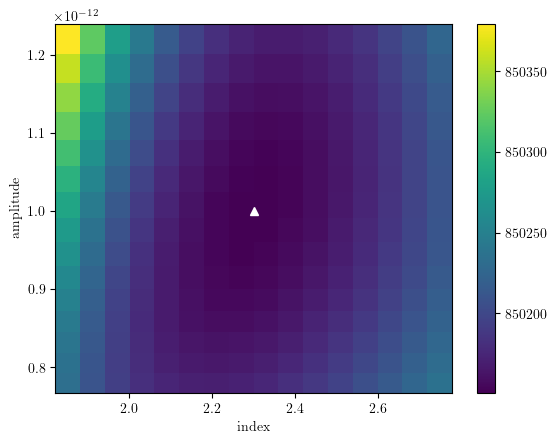

In [15]:
scan_nopti = compute_L("amplitude", "index", False)
print(np.shape(scan_nopti))
plot_imshow(scan_nopti, "amplitude", "index")


factor_amplitude = 1e-12
plt.plot(c_a_i['x'], np.array(c_a_i['y'])*factor_amplitude, '.-', label='Standard 1$\sigma$', color = 'red')
plt.plot(c95_a_i['x'], np.array(c95_a_i['y'])*factor_amplitude, '.-', label='Standard 2$\sigma$', color = 'red')

In [ ]:
scan_nopti= compute_L("lambda_", "index",  False)
plot_imshow(scan_nopti,  "lambda_", "index")

plt.plot(c_i_l['x'], np.array(c_i_l['y'])*factor_lambda, '.-', label='Standard 1$\sigma$', color = 'red')
plt.plot(c95_i_l['x'], np.array(c95_i_l['y'])*factor_lambda, '.-', label='Standard 2$\sigma$', color = 'red')

In [ ]:
scan_nopti = compute_L("amplitude", "lambda_",  False)

plot_imshow(scan_nopti,  "amplitude", "lambda_")

factor_amplitude = 1e-12
plt.plot(np.array(c_l_a['x'])*factor_lambda,
         np.array(c_l_a['y'])*factor_amplitude, '.-', label='Standard 1$\sigma$', color = 'red')
plt.plot(np.array(c95_l_a['x'])*factor_lambda,
         np.array(c95_l_a['y'])*factor_amplitude, '.-', label='Standard 2$\sigma$', color = 'red')  

## Reopt



In [ ]:
computing = 0
if computing :
    scan = compute_L("amplitude", "index", reopt=1, save = True)
else:
    scan, z_scan, z_scan = read_L("amplitude", "index")
plot_imshow(scan, "amplitude", "index")

factor_amplitude = 1e-12
plt.plot(c_a_i['x'], np.array(c_a_i['y'])*factor_amplitude, '.-', label='Standard 1$\sigma$', color = 'red')
plt.plot(c95_a_i['x'], np.array(c95_a_i['y'])*factor_amplitude, '.-', label='Standard 2$\sigma$', color = 'red')

## Creating the contour

In [ ]:
y_scan = scans['amplitude']
x_scan = scans['index']

#source = list(contour.keys())[0][:-24]
amplix__ = y_scan.copy()
indexy__ = x_scan.copy()
N_new = 110
N_new_y = 100
amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)


f = interp2d(
    x=indexy__,
    y=amplix__,
    z=scan,
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour = f(indexy__new, amplix__new)

In [ ]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))

#im = ax1.pcolormesh(amplix__, indexy__, scan)
im = ax1.pcolormesh(indexy__, amplix__, scan)

dddd = np.array(scan)
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel(
    "index",
)
ax1.set_title("Likelihood")


im = ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel(
    "index",
)
ax.set_title("Likelihood")

In [ ]:
threshold_contour = 2

(
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
) = compute_errors(
    data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
)
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    threshold_contour,
    find_min=True,
    color="lightblue",
)

dat = CS.allsegs[0][0]

plot_best_fit(plt.gca(), "index", "amplitude")


factor_amplitude = 1e-12
plt.plot(c_a_i['x'], np.array(c_a_i['y'])*factor_amplitude, '.-', 
         
         label='Standard 1$\sigma$', color = 'gold')
plt.plot(c95_a_i['x'], np.array(c95_a_i['y'])*factor_amplitude, '.-', 
         label='Standard 2$\sigma$', color = 'gold')



## lambda, index 

In [ ]:
computing = 0
if computing :
    scan = compute_L("lambda_", "index", reopt= 1, save = True)
else:
    scan, z_scan, z_scan = read_L("lambda_", "index")
plot_imshow(scan, "lambda_", "index")

In [ ]:
y_scan = scans['lambda_']
x_scan = scans['index']

#source = list(contour.keys())[0][:-24]
amplix__ = y_scan.copy()
indexy__ = x_scan.copy()
N_new = 110
N_new_y = 100
amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)


f = interp2d(
    x=indexy__,
    y=amplix__,
    z=scan,
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour = f(indexy__new, amplix__new)

In [ ]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))

#im = ax1.pcolormesh(amplix__, indexy__, scan)
im = ax1.pcolormesh(indexy__, amplix__, scan)

dddd = np.array(scan)
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel(
    "index",
)
ax1.set_title("Likelihood")


im = ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel(
    "index",
)
ax.set_title("Likelihood")

In [ ]:
plot_best_fit(plt.gca(), "lambda_", "index")

In [ ]:
threshold_contour = 2

(
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
) = compute_errors(
    data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
)
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    threshold_contour,
    find_min=True,
    color="lightblue",
)

dat = CS.allsegs[0][0]

plot_best_fit(plt.gca(),"index", "lambda_", )


factor_amplitude = 1e-12
plt.plot(c_i_l['x'], np.array(c_i_l['y'])*factor_lambda, '.-', 
         label='Standard 1$\sigma$', color = 'gold')
plt.plot(c95_i_l['x'], np.array(c95_i_l['y'])*factor_lambda, '.-', 
             label='Standard 2$\sigma$', color = 'gold')




##  amplitude lambda

In [ ]:
computing = 0
if computing :
    scan = compute_L("amplitude", "lambda_", reopt= 1, save = True)
else:
    scan, z_scan, z_scan = read_L("amplitude", "lambda_")
plot_imshow(scan,  "amplitude", "lambda_")